In [1]:
import bisect
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import math
import seaborn as sns
#import plotly.graph_objects as go
from scipy.stats import norm
sns.set()

In [2]:
start_date = '2005-06-28'
end_date = '2022-02-27'
time_interval = '1d'

tickers_list = []
with open('Stocks List.txt') as text_file:
    for line in text_file:
        temp_str = line.replace('\n', '', 1)
        tickers_list.append(temp_str)
    
stock_basket = {}

In [7]:
#TO DOWNLOAD AND SAVE
for ticker in tickers_list:
    stock_basket[ticker] = yf.download(ticker, start = start_date, end = end_date, interval = time_interval)
    temp_date = str(stock_basket[ticker].index[0].date())
    filename = ticker + 'Price Data'
    stock_basket[ticker].to_csv('Stocks Data/' + filename)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [3]:
#TO LOAD ONLY
for ticker in tickers_list:
    filename = ticker + 'Price Data'
    stock_basket[ticker] = pd.read_csv('Stocks Data/' + filename)
    stock_basket[ticker]['EMA50'] = stock_basket[ticker]['Adj Close'].ewm(com = 50, min_periods = 50).mean()
    stock_basket[ticker]['EMA100'] = stock_basket[ticker]['Adj Close'].ewm(com = 100, min_periods = 100).mean()

In [4]:
#HCLTECH.NS   4113, so use that for the date column for all stocks
def conv_str_to_date(date_str):
    return dt.datetime.strptime(str(date_str), '%Y-%m-%d').date()

def conv_strSer_to_dateSer(str_ser):
    n = len(str_ser)
    newSer = []
    for i in range(0, n):
        newSer.append(conv_str_to_date(str_ser[i]))
    return pd.Series(newSer)

def countCol(date_ser):
    n = len(date_ser)
    temp_list = np.zeros(n)
    for i in range(0, n):
        temp_list[i] = i
    return pd.Series(temp_list)

for ticker in tickers_list:
    if (stock_basket[ticker].index.name != 'Date'):
        stock_basket[ticker]['Date'] = conv_strSer_to_dateSer(stock_basket[ticker]['Date'])
        stock_basket[ticker].set_index('Date', inplace = True, drop = True)

In [163]:
#REDOING THE BACKTESTING COMPLETELY WITH DEPLOYING ONLY 20% OF CAPITAL FOR EVERY TRADE
def prevHigh(stock_data, index, n):
    if (index - n < 0):
        return -1
    high = max(stock_data['Adj Close'][index - n:index])
    return high

def getRowByDate(stock_data, date):
    v = bisect.bisect_left(stock_data.index, date)
    if (stock_data.index[v] != date):
        return stock_data[v:v+1], -1
    else:
        return stock_data[v:v+1], v

def searchActiveTrades(active_trades, ticker):
    count = 0
    for row in active_trades:
        if ticker == row[1]:
            return count
        count += 1
    return -1

def emaRatio(ticker, date):
    row, _ = getRowByDate(stock_basket[ticker], date)
    return (row['EMA50'][0] / row['EMA100'][0])

#ALSO NEED THE PREV DATE AS DECISION TODAY IS BASED ON PREVIOUS DAY
def createRankTable(prev_date, date, active_trades, t):
    rank_table = []
    #CHECK IF DATA ENTRY EXISTS ON THAT DATE FOR THE DATA
    for ticker in tickers_list:
        if searchActiveTrades(active_trades, ticker) == -1:
            ticker_row, rownum = getRowByDate(stock_basket[ticker], prev_date)
            if rownum != -1 and ticker_row['Adj Close'][0] >= prevHigh(stock_basket[ticker], rownum, t):
                rank_table.append([ticker, (ticker_row['EMA50'][0] / ticker_row['EMA100'][0])])

    rank_table.sort(key = lambda x: x[1], reverse = True)
    return rank_table

def buyStock(ticker, prev_date, date, active_trades, trade_capital, total_capital, available_capital):
    stock_data_row, rownum = getRowByDate(stock_basket[ticker], date)
    if (rownum != -1):
        buy_price = stock_data_row['Adj Close'][0]
        shares = np.floor(trade_capital / buy_price)
        if (shares > 0):
            trade_capital = shares * buy_price
            available_capital -= trade_capital
            active_trades.append([date, ticker, shares, buy_price])
    return active_trades, available_capital

def getSellList(prev_date, date, active_trades, target_ratio, sl_ratio):
    #TODAY'S SELL DECISION BASED ON YESTERDAY'S PRICES
    sell_list = []
    for row in active_trades:
        #CHECK IF DATA ENTRY EXISTS FOR THE PREVIOUS DAY
        ticker_row, ticker_rownum = getRowByDate(stock_basket[row[1]], prev_date)
        if ticker_rownum != -1:
            bprice = row[3]
            sprice = ticker_row['Adj Close'][0]

            if (sprice / bprice >= target_ratio or sprice / bprice <= sl_ratio):
                sell_list.append(row[1])

    return sell_list

def sellStock(ticker, prev_date, date, trades_history, active_trades, available_capital, total_capital):
    stock_data_row, rownum = getRowByDate(stock_basket[ticker], date)
    #CHECK IF THERE IS A DATA ENTRY FOR TODAY
    if rownum != -1:
        at_row_num = searchActiveTrades(active_trades, ticker)

        buy_date = active_trades[at_row_num][0]
        shares = active_trades[at_row_num][2]
        buy_price = active_trades[at_row_num][3]
        sell_price = stock_data_row['Adj Close'][0]
        returns = ((sell_price - buy_price) * 100) / buy_price
        trh_row = [ticker, buy_date, date, shares, buy_price, sell_price, returns]

        trades_history = trades_history.append(pd.Series(trh_row, index = trades_history.columns), ignore_index = True)
        active_trades.pop(at_row_num)

        prof_or_loss = shares * (sell_price - buy_price)
        available_capital += shares * sell_price
        total_capital += prof_or_loss
    return trades_history, active_trades, available_capital, total_capital

def active_trades_worth(active_trades, date):
    res = 0
    for row in active_trades: 
        ticker = row[1]
        last_index = stock_basket[ticker].shape[0] - 1
        stock_row = stock_basket[ticker][last_index:last_index + 1]
        shares = row[2]
        cur_price = stock_row['Adj Close'][0]
        res += shares * cur_price
    return res

#OFFSET BY 100 FOR EMA 100 DATA
date_col = stock_basket['HCLTECH.NS'].index 
#SLICING DATE COLUMN TO USE IN FINAL FOR LOOP
prev_date = date_col[101:102][0]
date_col = date_col[102:len(date_col) - 1]
total_capital = 50000
available_capital = total_capital
trade_capital = 0.2 * total_capital
trades_history = pd.DataFrame(columns = ['Ticker', 'Buy Date', 'Sell Date', 'Shares', 'Buy Price', 'Sell Price', '% Return'])
year_total_capital_list = []
#active_trades = pd.DataFrame(columns = ['Date', 'Ticker', 'Shares', 'Price'])
active_trades = []
t = 100
target_ratio = 1.75
sl_ratio = 0.82
days_total = len(date_col)
days_start = 0

for date in date_col:
    #CHECK IF ATLEAST TRADE CAPITAL IS AVAILABLE AND THEN BUY IF AVAILABLE
    trade_capital = 0.2 * total_capital
    if available_capital >= trade_capital:
        #CREATE A RANK TABLE, PARAMETERS BEING IF THE STOCK CROSSED ITS t DAYS HIGH
        #THEN COMPARE THEM BY THEIR EMA RATIO OF 50 TO 100, PREFERENCE TO THE HIGHER
        rank_table = createRankTable(prev_date, date, active_trades, t)
        no_comp_alloc = int(np.floor(available_capital / trade_capital))

        rank_table = rank_table[0:no_comp_alloc]

        for row in rank_table:
            #EXECUTE ALL BUY ORDERS, ACTIVE TRADES IS PASSED BY REFERENCE AND ONLY UPDATED WITHOUT ASSIGNING, HENCE NO NEED TO RETURN IT
            active_trades, available_capital = buyStock(row[0], prev_date, date, active_trades, trade_capital, total_capital, available_capital) 
        
    if len(active_trades) > 0:
        sell_list = getSellList(prev_date, date, active_trades, target_ratio, sl_ratio)
        if len(sell_list) > 0:
            for ticker in sell_list:
                trades_history, active_trades, available_capital, total_capital = sellStock(ticker, prev_date, date, trades_history, 
                                                                                            active_trades, available_capital, total_capital)
        
    
    #ADDING Rs. 10000 after every 30 trading days
    if (days_start % 30 == 0):
        princ = 10000
        total_capital += princ
        available_capital += princ
        
    #FINAL LOOP UPDATES
    if (date.year - prev_date.year == 1):
        year_total_capital_list.append(total_capital) 
    days_start += 1
    if (days_start % 250 == 0):
        print(days_start, '/', days_total)
    prev_date = date


at_worth = active_trades_worth(active_trades, conv_str_to_date(end_date))
print("\nCapital (Currency, Stocks): ( Rs.", round(total_capital, 2), ", Rs.", round(at_worth, 2), ")")
print("\nTotal Capital: Rs.", round(total_capital + at_worth, 2))
trades_history

250 / 4010
500 / 4010
750 / 4010
1000 / 4010
1250 / 4010
1500 / 4010
1750 / 4010
2000 / 4010
2250 / 4010
2500 / 4010
2750 / 4010
3000 / 4010
3250 / 4010
3500 / 4010
3750 / 4010
4000 / 4010

Capital (Currency, Stocks): ( Rs. 15920854.36 , Rs. 15865182.32 )

Total Capital: Rs. 31786036.67


,Ticker,Buy Date,Sell Date,Shares,Buy Price,Sell Price,% Return
0,CIPLA.NS,2005-11-25,2006-04-07,67.0,147.897125,263.870605,78.414966
1,BAJFINANCE.NS,2006-02-23,2006-05-19,361.0,44.206493,34.761833,-21.364871
2,TATACONSUM.NS,2005-11-25,2006-05-22,152.0,65.455536,48.732731,-25.548343
3,SHREECEM.NS,2006-04-10,2006-05-24,19.0,983.969788,808.293152,-17.853865
4,JINDALSTEL.NS,2006-01-09,2006-06-09,273.0,51.099495,42.071297,-17.667882
...,...,...,...,...,...,...,...
73,HDFCLIFE.NS,2018-01-02,2021-01-05,3804.0,392.580750,711.649841,81.274768
74,SBICARD.NS,2020-03-23,2021-01-25,2682.0,581.318787,1021.500000,75.721140
75,APOLLOHOSP.NS,2021-01-27,2021-08-18,970.0,2598.814453,4787.899902,84.234003
76,LTI.NS,2021-01-06,2021-10-21,583.0,3915.130859,6638.048340,69.548569


1.60, 0.85, t = 50, 100, 30 (ascending order of performance, no extra SIP)!!
t = 100, best with 10000 SIP!!
1.4, 0.9, t = 30, seems to be best performance with close to 4:1 Win loss ratio and 50% win percentage!!
1.8, 0.8, t= 50!!
1.75, 0.82, t = 100!!

Number of Trades: 78
Win Percentage: 56.41 %
Average Win: 84.5 %
Average Loss: -22.12 %
Expected Value: 38.02 %
Effective Win-Loss Ratio: 3.82:1


          Ticker  Frequency
0  BAJFINANCE.NS          4
1    SHREECEM.NS          4
2    ADANIENT.NS          4
3  ADANIPORTS.NS          3
4  HINDUNILVR.NS          3


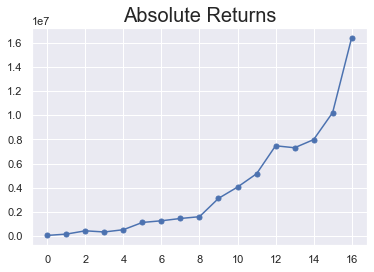

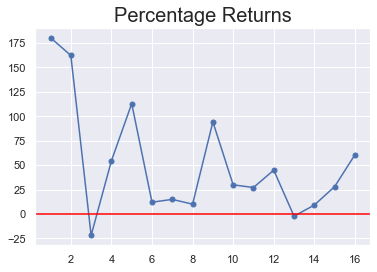

In [164]:
win_percentage = 0
wins = 0
avg_win_col = [] 
avg_loss_col = []

returns_col = list(trades_history['% Return'])

for returns in returns_col:
    if returns > 0:
        wins += 1
        avg_win_col.append(returns)
    else:
        avg_loss_col.append(returns)
        
avg_win = np.mean(np.array(avg_win_col))
avg_loss = np.mean(np.array(avg_loss_col))
win_perc = (wins / len(returns_col))

print("Number of Trades:", len(returns_col))
print("Win Percentage:", round(win_perc * 100, 2), "%")
print("Average Win:", round(avg_win, 2), "%")
print("Average Loss:", round(avg_loss, 2), "%")
print("Expected Value:", round((((avg_win * win_perc) + (avg_loss * (1 - win_perc)))), 2), "%")
print("Effective Win-Loss Ratio:", str(round(abs(avg_win / avg_loss), 2)) + ":1") 
print("\n")
freq_list = []
trades_list = list(trades_history['Ticker'])
for ticker in tickers_list:
    temp_freq = trades_list.count(ticker)
    if temp_freq > 0:
        freq_list.append([ticker, temp_freq])
    
freq_table = pd.DataFrame(freq_list, columns = ['Ticker', 'Frequency']).sort_values(by = ['Frequency'], ascending = False)
freq_table.reset_index(inplace = True, drop = True)
print(freq_table.head())


ytcl_size = len(year_total_capital_list)
years_list = []
ytcl_perc_change = []
for i in range(1, ytcl_size):
    ytcl_perc_change.append(((year_total_capital_list[i] / year_total_capital_list[i - 1]) - 1) * 100)
    years_list.append(i)
    
plt.plot(year_total_capital_list, marker = '.', markersize = 10)
plt.title('Absolute Returns', fontsize = 20)
plt.show()
plt.plot(years_list, ytcl_perc_change, marker = '.', markersize = 10)
plt.axhline(y = 0.0, color = 'red')
plt.title('Percentage Returns', fontsize = 20)
plt.show()
plt.show()

In [165]:
active_trades

[[datetime.date(2020, 7, 17), 'DRREDDY.NS', 435.0, 4081.14306640625],
 [datetime.date(2020, 7, 17), 'CIPLA.NS', 2595.0, 685.319091796875],
 [datetime.date(2020, 11, 24), 'DIVISLAB.NS', 579.0, 3522.610107421875],
 [datetime.date(2021, 8, 20), 'BAJAJFINSV.NS', 197.0, 14978.5498046875],
 [datetime.date(2021, 10, 22), 'SBIN.NS', 6512.0, 502.9500122070313],
 [datetime.date(2022, 1, 27), 'POWERGRID.NS', 15222.0, 209.0418243408203]]

Mean: 423.88461538461536 days


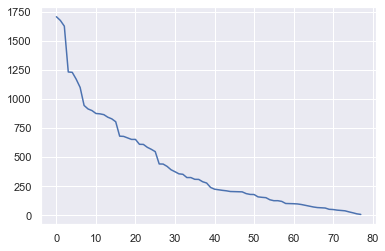

In [166]:
#average trading period
time_btw_trades = []
len_trades_hist = trades_history.shape[0]
for i in range(0, len_trades_hist):
    sell_date = trades_history.loc[i].at['Sell Date']
    buy_date = trades_history.loc[i].at['Buy Date']
    time_btw_trades.append((sell_date - buy_date).days)
    
time_btw_trades.sort(reverse = True)
print('Mean:', sum(time_btw_trades) / len(time_btw_trades), 'days')
plt.plot(time_btw_trades)
plt.show()